# Item Sales Prediction

## Common Imports

In [1]:
%load_ext dotenv
%dotenv

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import os
import opendatasets as od 
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import (FunctionTransformer, OneHotEncoder, StandardScaler, 
                                QuantileTransformer, KBinsDiscretizer, RobustScaler,
                                MinMaxScaler)
from xgboost import XGBRegressor

sns.set_palette("viridis")

## Data

### Load the data from Kaggle

In [3]:
KAGGLE_USER=os.getenv("KAGGLE_USER_NAME")
KAGGLE_API=os.getenv("KAGGLE_API_KEY")

In [4]:
od.download("https://www.kaggle.com/datasets/sushantbmujagule/big-sales-prediction-dataset/data/Big Sales Data.csv")

Skipping, found downloaded files in "./big-sales-prediction-dataset" (use force=True to force download)


In [5]:
dataset = pd.read_csv("big-sales-prediction-dataset/Big Sales Data.csv")
dataset.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDT36,12.3,Low Fat,0.111448,Baking Goods,33.4874,OUT049,1999,Medium,Tier 1,Supermarket Type1,436.608721
1,FDT36,12.3,Low Fat,0.111904,Baking Goods,33.9874,OUT017,2007,Medium,Tier 2,Supermarket Type1,443.127721
2,FDT36,12.3,LF,0.111728,Baking Goods,33.9874,OUT018,2009,Medium,Tier 3,Supermarket Type2,564.598400
3,FDT36,12.3,Low Fat,0.000000,Baking Goods,34.3874,OUT019,1985,Small,Tier 1,Grocery Store,1719.370000
4,FDP12,9.8,Regular,0.045523,Baking Goods,35.0874,OUT017,2007,Medium,Tier 2,Supermarket Type1,352.874000


### Data Exploration

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                11815 non-null  float64
 2   Item_Fat_Content           14204 non-null  object 
 3   Item_Visibility            14204 non-null  float64
 4   Item_Type                  14204 non-null  object 
 5   Item_MRP                   14204 non-null  float64
 6   Outlet_Identifier          14204 non-null  object 
 7   Outlet_Establishment_Year  14204 non-null  int64  
 8   Outlet_Size                14204 non-null  object 
 9   Outlet_Location_Type       14204 non-null  object 
 10  Outlet_Type                14204 non-null  object 
 11  Item_Outlet_Sales          14204 non-null  float64
dtypes: float64(4), int64(1), object(7)
memory usage: 1.3+ MB


In [7]:
dataset.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,11815.000000,14204.000000,14204.000000,14204.000000,14204.000000
mean,12.788355,0.065953,141.004977,1997.830681,2185.836320
std,4.654126,0.051459,62.086938,8.371664,1827.479550
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.710000,0.027036,94.012000,1987.000000,922.135101
50%,12.500000,0.054021,142.247000,1999.000000,1768.287680
75%,16.750000,0.094037,185.855600,2004.000000,2988.110400
max,30.000000,0.328391,266.888400,2009.000000,31224.726950


In [8]:
dataset.isna().sum()

Item_Identifier                 0
Item_Weight                  2389
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [9]:
# create a copy to perform data transformations
data = dataset.copy(deep=True)

#### Target Column: Item_Outlet_Sales

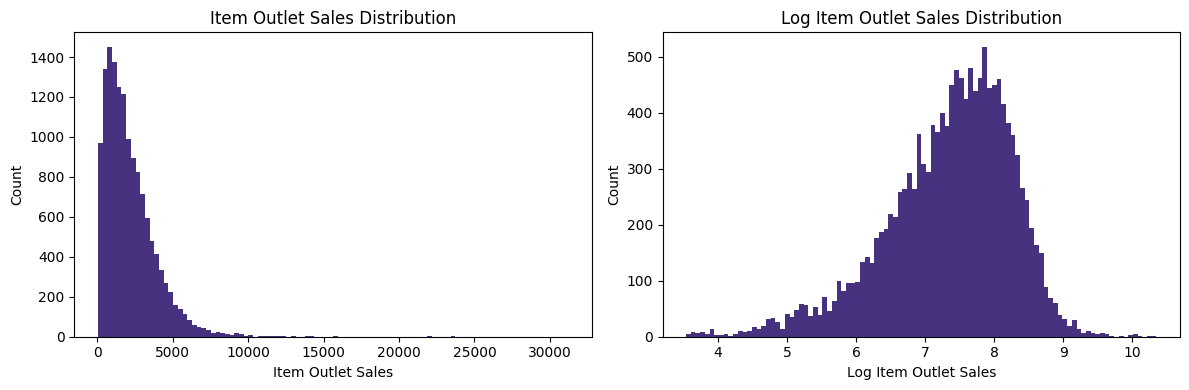

In [10]:
# apply log transformation to the target feature
data["Item_Outlet_Sales_log"] = data["Item_Outlet_Sales"].apply(np.log1p)

_, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(data["Item_Outlet_Sales"], bins=100, )
ax[1].hist(data["Item_Outlet_Sales_log"], bins=100)
ax[0].set_title("Item Outlet Sales Distribution")
ax[1].set_title("Log Item Outlet Sales Distribution")
ax[0].set_xlabel("Item Outlet Sales")
ax[1].set_xlabel("Log Item Outlet Sales")
ax[0].set_ylabel("Count")
ax[1].set_ylabel("Count")
plt.tight_layout()
plt.show()

#### Item_Identifier

In [11]:
item_ids = data.loc[:, "Item_Identifier"].unique()
print("Number of unique item identifiers:", len(item_ids))
print("Item identifiers sample:\n", item_ids[:30])

Number of unique item identifiers: 1559
Item identifiers sample:
 ['FDT36' 'FDP12' 'FDQ36' 'FDW23' 'FDM60' 'FDR36' 'FDO60' 'FDK24' 'FDL48'
 'FDK36' 'FDW24' 'FDP36' 'FDY12' 'FDI48' 'FDY24' 'FDN24' 'FDL12' 'FDI60'
 'FDY11' 'FDY36' 'FDK48' 'FDT24' 'FDR60' 'FDV48' 'FDX60' 'FDW48' 'FDC48'
 'FDF24' 'FDG24' 'FDH48']


#### Item_Weight

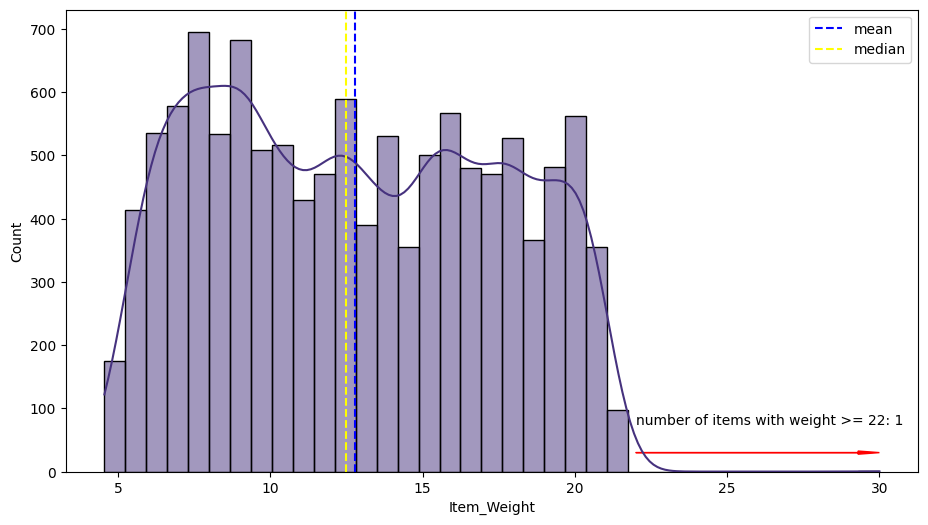

In [12]:
plt.figure(figsize=(11, 6))
sns.histplot(data, x="Item_Weight", kde=True)
plt.axvline(data["Item_Weight"].mean(), color="b", linestyle="--", label="mean")
plt.axvline(data["Item_Weight"].median(), color="yellow", linestyle="--", label="median")
plt.legend()
plt.arrow(22, 30, 8, 0, width=0.01, color="r", length_includes_head=True, head_width=5, head_length=0.7)
plt.text(22, 75, f"number of items with weight >= 22: {len(data[data.loc[:, 'Item_Weight'] >= 22])}")
plt.show()

In [13]:
data.loc[data["Item_Weight"].isna()]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Outlet_Sales_log
269,FDH48,NaN,Low Fat,0.105893,Baking Goods,86.2540,OUT019,1985,Small,Tier 1,Grocery Store,519.324000,6.254452
272,FDS24,NaN,Regular,0.108947,Baking Goods,86.5514,OUT019,1985,Small,Tier 1,Grocery Store,794.435600,6.678890
279,FDS24,NaN,Regular,0.061923,Baking Goods,87.5514,OUT027,1985,Medium,Tier 3,Supermarket Type3,1413.871780,7.254794
280,FDC60,NaN,Regular,0.113918,Baking Goods,87.9514,OUT027,1985,Medium,Tier 3,Supermarket Type3,772.058409,6.650355
287,FDL36,NaN,Low Fat,0.075707,Baking Goods,88.1830,OUT027,1985,Medium,Tier 3,Supermarket Type3,1438.128000,7.271793
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14176,FDF11,NaN,Regular,0.000000,Starchy Foods,238.3538,OUT027,1985,Medium,Tier 3,Supermarket Type3,11917.690000,9.385863
14188,FDD11,NaN,Low Fat,0.053606,Starchy Foods,252.4040,OUT019,1985,Small,Tier 1,Grocery Store,4708.507347,8.457339
14192,FDD11,NaN,Low Fat,0.030468,Starchy Foods,254.7040,OUT027,1985,Medium,Tier 3,Supermarket Type3,3036.048000,8.018641
14197,FDG47,NaN,Low Fat,0.121894,Starchy Foods,261.3252,OUT019,1985,Small,Tier 1,Grocery Store,2143.879527,7.670839


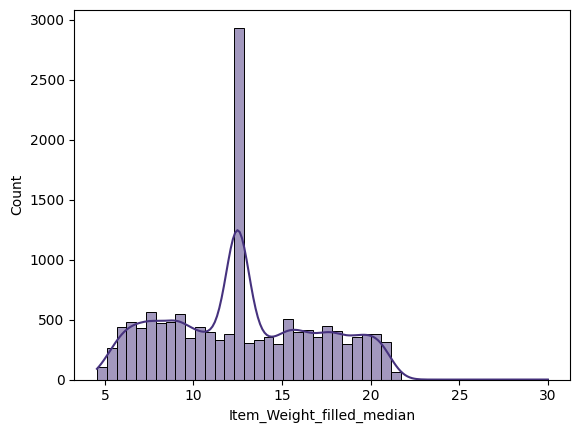

In [14]:
# fill NaNs weights with weights median value which is closer to the peak
data["Item_Weight_filled_median"] = data["Item_Weight"].fillna(data["Item_Weight"].median())
# plot hte resulting distribution
sns.histplot(data, x="Item_Weight_filled_median", kde=True)
plt.show()

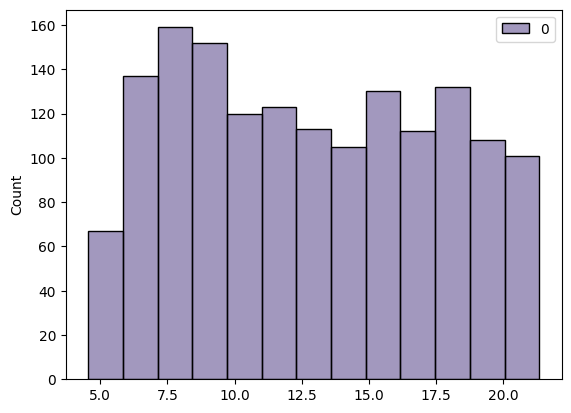

In [15]:
# compute median and mean item weights by item identifier and item type 
replace_dict_id = data.groupby("Item_Identifier")["Item_Weight"].agg(["mean", "median"]).to_dict()
replace_dict_type = data.groupby("Item_Type")["Item_Weight"].agg(["mean", "median"]).to_dict()
# items median weights distribution grouped by item identifier
sns.histplot(replace_dict_id["mean"].values())
plt.show()

In [16]:
data["Item_Weight_filled_by_type"] = data["Item_Weight"].fillna(data["Item_Type"].map(replace_dict_type["mean"]))
data["Item_Weight_filled_by_id"] = data["Item_Weight"].fillna(data["Item_Identifier"].map(replace_dict_id["mean"]))

In [17]:
data[["Item_Outlet_Sales", "Item_Weight", "Item_Weight_filled_median", "Item_Weight_filled_by_id", "Item_Weight_filled_by_type"]].corr()

,Item_Outlet_Sales,Item_Weight,Item_Weight_filled_median,Item_Weight_filled_by_id,Item_Weight_filled_by_type
Item_Outlet_Sales,1.000000,0.228297,0.155303,0.145037,0.160823
Item_Weight,0.228297,1.000000,1.000000,1.000000,1.000000
Item_Weight_filled_median,0.155303,1.000000,1.000000,0.911525,0.998121
Item_Weight_filled_by_id,0.145037,1.000000,0.911525,1.000000,0.913174
Item_Weight_filled_by_type,0.160823,1.000000,0.998121,0.913174,1.000000


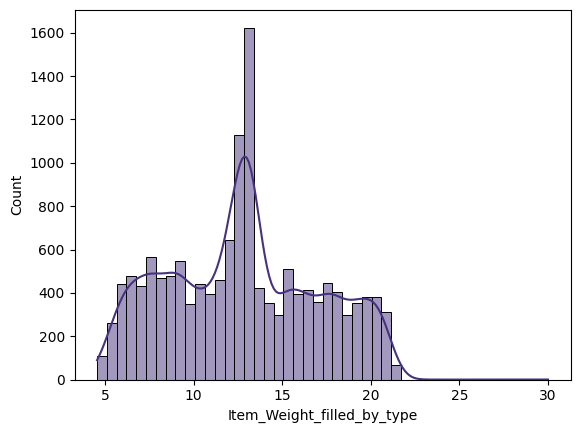

In [18]:
sns.histplot(data, x="Item_Weight_filled_by_type", kde=True)
plt.show()

#### Item_Fat_Content

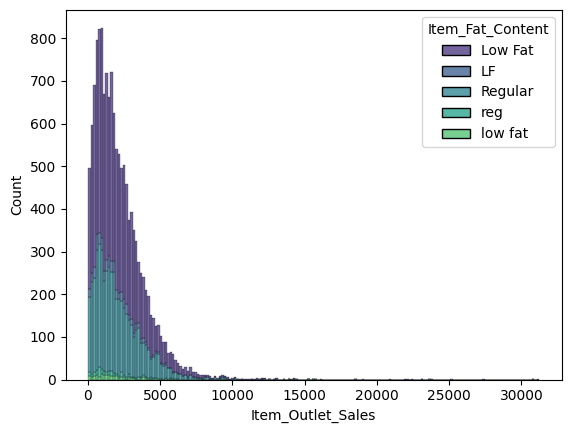

In [19]:
sns.histplot(hue="Item_Fat_Content", x="Item_Outlet_Sales", multiple="stack", data=data)
plt.show()

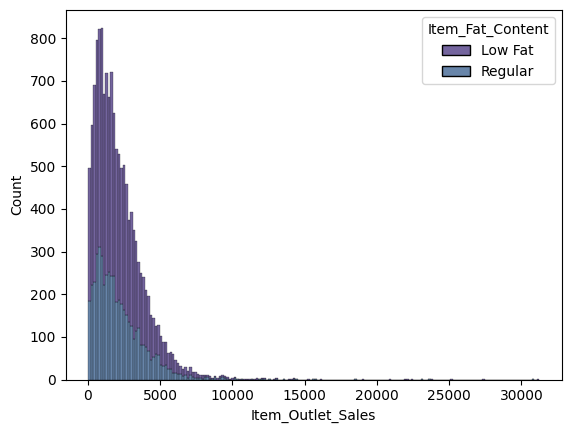

In [20]:
data["Item_Fat_Content"] = data.loc[:, "Item_Fat_Content"].replace({"LF": "Low Fat", "low fat": "Low Fat", "reg": "Regular"})
sns.histplot(hue="Item_Fat_Content", x="Item_Outlet_Sales", multiple="stack", data=data)
plt.show()

#### Item_Visibility

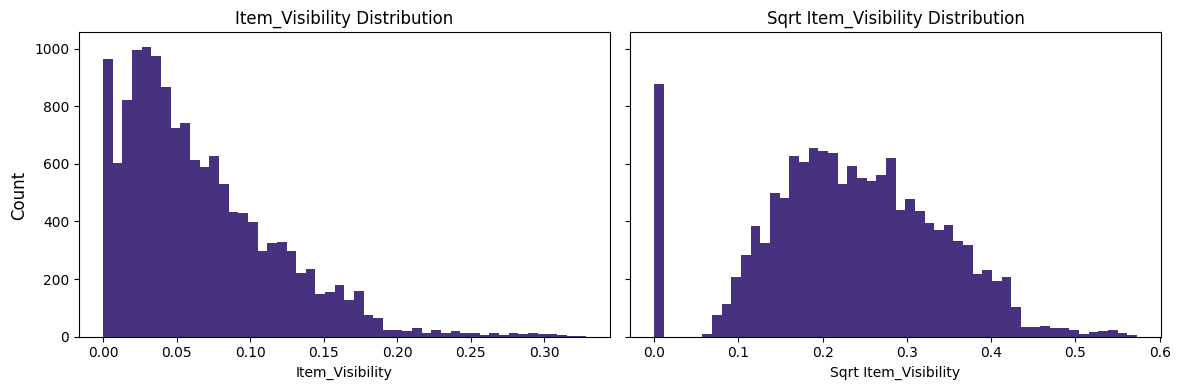

In [95]:
data["Item_Visibility_sqrt"] = data["Item_Visibility"].map(np.sqrt)

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
ax[0].hist(data["Item_Visibility"], bins=50)
ax[1].hist(data["Item_Visibility_sqrt"], bins=50)
ax[0].set_title("Item_Visibility Distribution")
ax[1].set_title("Sqrt Item_Visibility Distribution")
ax[0].set_xlabel("Item_Visibility")
ax[1].set_xlabel("Sqrt Item_Visibility")
fig.supylabel("Count")
plt.tight_layout()
plt.show()

#### Item_Type

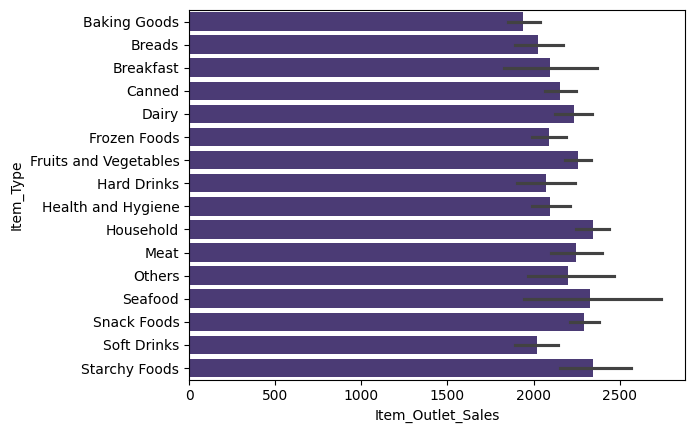

In [22]:
sns.barplot(data, y="Item_Type", x="Item_Outlet_Sales")
plt.show()

#### Item_MRP

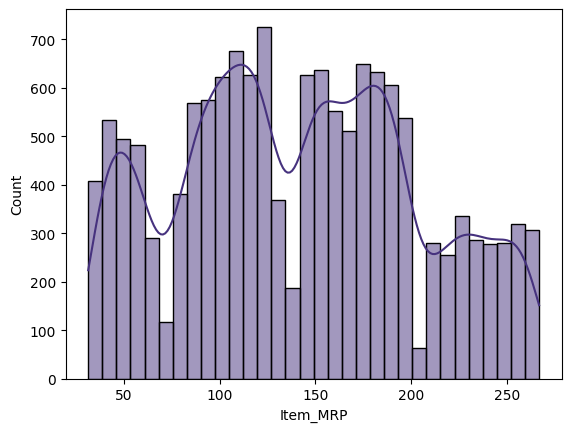

In [23]:
sns.histplot(x="Item_MRP", data=data, kde=True)
plt.show()

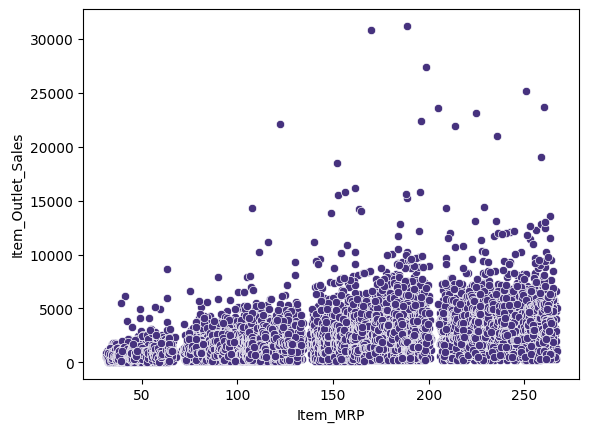

In [24]:
sns.scatterplot(data, y="Item_Outlet_Sales", x="Item_MRP")
plt.show()

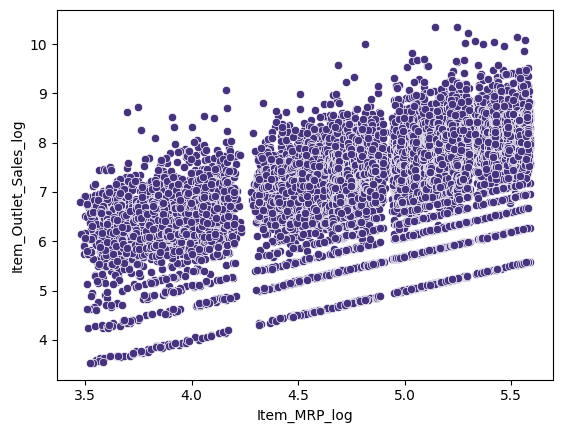

In [142]:
data["Item_MRP_log"] = data["Item_MRP"].map(np.log1p)
sns.scatterplot(data, y="Item_Outlet_Sales_log", x="Item_MRP_log")
plt.show()

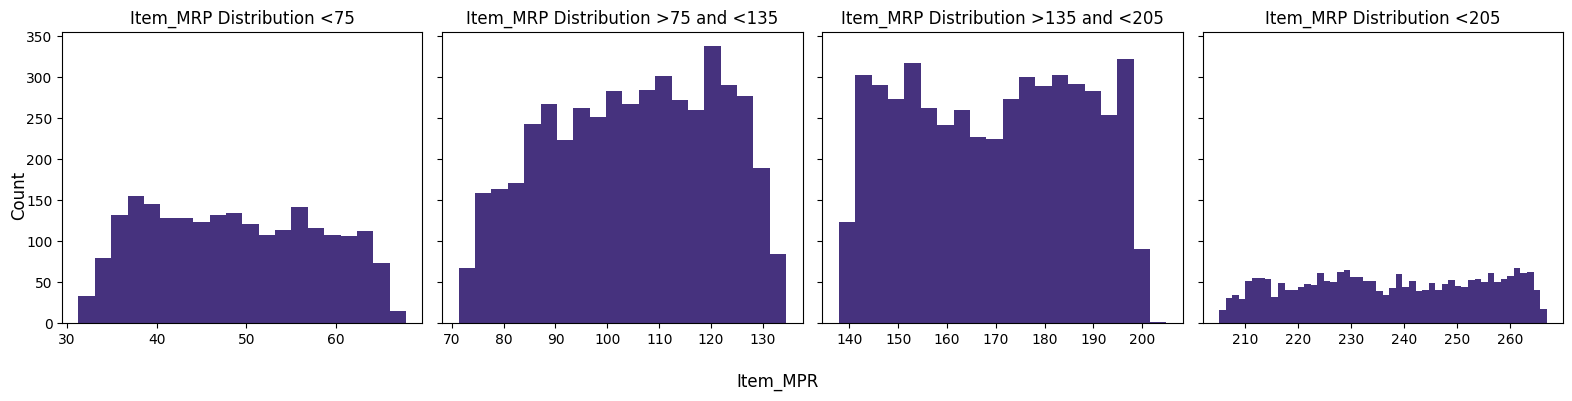

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4), sharey=True)
ax[0].hist(data.loc[data.loc[:, "Item_MRP"] <= 70, "Item_MRP"], bins=20)
ax[1].hist(data.loc[(data.loc[:, "Item_MRP"] > 70) & (data.loc[:, "Item_MRP"] <= 135), "Item_MRP"], bins=20)
ax[2].hist(data.loc[(data.loc[:, "Item_MRP"] > 135) & (data.loc[:, "Item_MRP"] <= 205), "Item_MRP"], bins=20)
ax[3].hist(data.loc[data.loc[:, "Item_MRP"] > 205, "Item_MRP"], bins=50)
ax[0].set_title("Item_MRP Distribution <75")
ax[1].set_title("Item_MRP Distribution >75 and <135")
ax[2].set_title("Item_MRP Distribution >135 and <205")
ax[3].set_title("Item_MRP Distribution <205")
fig.supxlabel("Item_MPR")
fig.supylabel("Count")
plt.tight_layout()
plt.show()

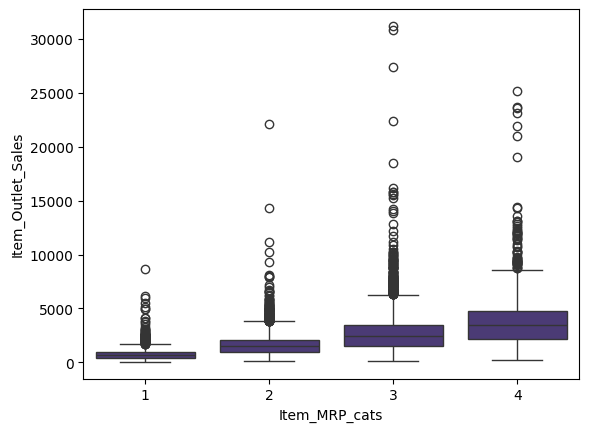

In [26]:
# create MPR categories
data["Item_MRP_cats"] = pd.cut(data.loc[:, "Item_MRP"], bins=[0, 75, 135, 205, 300], labels=[1, 2, 3, 4])
sns.boxplot(data, y="Item_Outlet_Sales", x="Item_MRP_cats")
plt.show()

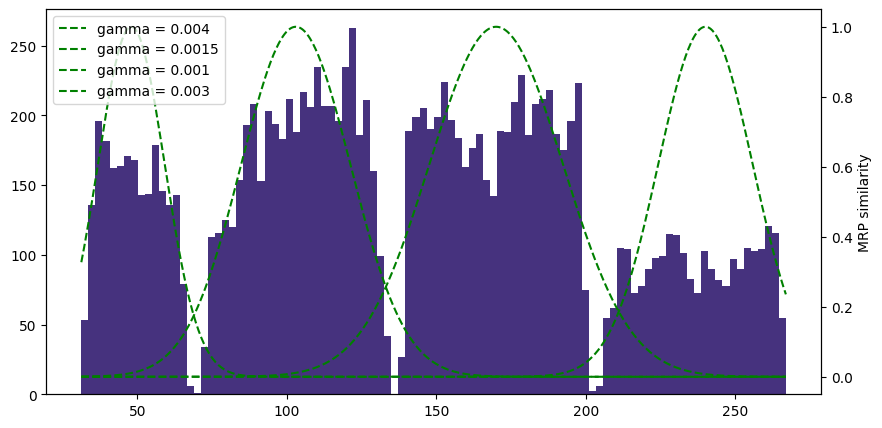

In [27]:
# transform Item_MRP using RBF kernels
from sklearn.metrics.pairwise import rbf_kernel

mrps = np.linspace(data["Item_MRP"].min(),
                   data["Item_MRP"].max(),
                   500).reshape(-1, 1)

simil_48 = rbf_kernel(mrps, [[48]], gamma=0.004)
simil_103 = rbf_kernel(mrps, [[103]], gamma=0.0015)
simil_165 = rbf_kernel(mrps, [[170]], gamma=0.001)
simil_240 = rbf_kernel(mrps, [[240]], gamma=0.002)

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.hist(data["Item_MRP"], bins=100)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "black"
ax2.plot(mrps, simil_48, color="g", label="gamma = 0.004", linestyle="--")
ax2.plot(mrps, simil_103, color="g", label="gamma = 0.0015", linestyle="--")
ax2.plot(mrps, simil_165, color="g", label="gamma = 0.001", linestyle="--")
ax2.plot(mrps, simil_240, color="g", label="gamma = 0.003", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("MRP similarity", color=color)

plt.legend(loc="upper left")
plt.show()

In [28]:
# add new features to the data
data[["MRP48_simil"]] = rbf_kernel(data[["Item_MRP"]], [[48]], gamma=0.004)
data[["MRP103_simil"]] = rbf_kernel(data[["Item_MRP"]], [[103]], gamma=0.0015)
data[["MRP170_simil"]] = rbf_kernel(data[["Item_MRP"]], [[170]], gamma=0.001)
data[["MRP240_simil"]] = rbf_kernel(data[["Item_MRP"]], [[240]], gamma=0.002)

In [29]:
data[["MRP48_simil", "MRP103_simil", "MRP170_simil", "MRP240_simil", "Item_Outlet_Sales_log"]].corr()

,MRP48_simil,MRP103_simil,MRP170_simil,MRP240_simil,Item_Outlet_Sales_log
MRP48_simil,1.000000,-0.258204,-0.325821,-0.170575,-0.450774
MRP103_simil,-0.258204,1.000000,-0.452605,-0.284431,-0.149048
MRP170_simil,-0.325821,-0.452605,1.000000,-0.287078,0.258566
MRP240_simil,-0.170575,-0.284431,-0.287078,1.000000,0.298438
Item_Outlet_Sales_log,-0.450774,-0.149048,0.258566,0.298438,1.000000


#### Outlet_Identifier

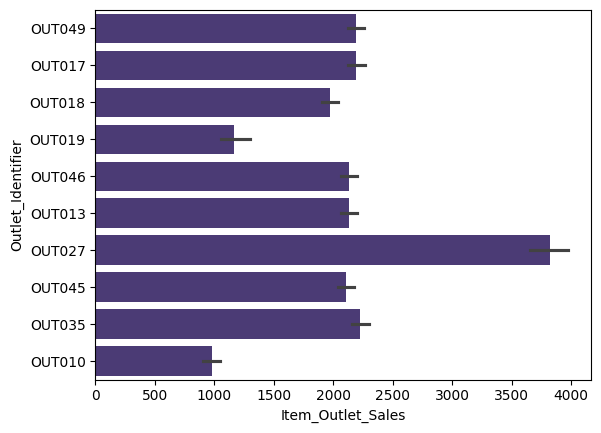

In [30]:
sns.barplot(data, y="Outlet_Identifier", x="Item_Outlet_Sales")
plt.show()

#### Outlet_Establishment_Year

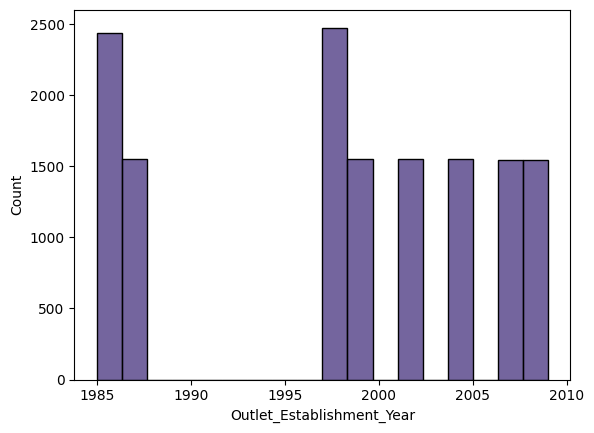

In [31]:
sns.histplot(x="Outlet_Establishment_Year", data=data)
plt.show()

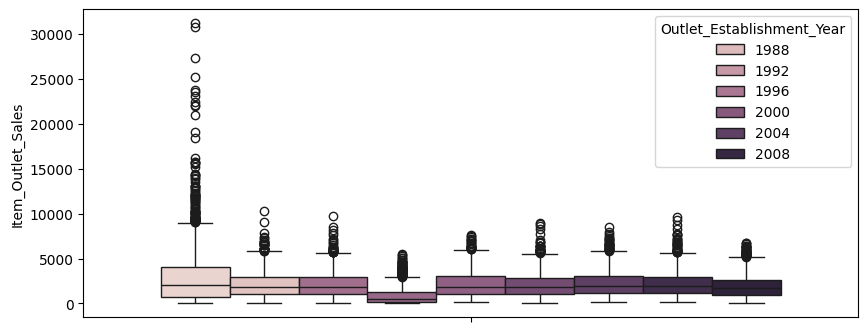

In [32]:
plt.figure(figsize=(10, 4))
sns.boxplot(hue="Outlet_Establishment_Year", y="Item_Outlet_Sales", data=data)
plt.show()

#### Outlet_Size

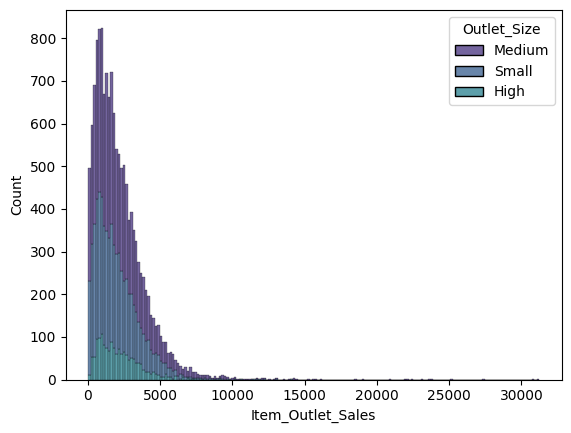

In [33]:
sns.histplot(x="Item_Outlet_Sales", hue="Outlet_Size", multiple="stack", data=data)
plt.show()

#### Outlet_Location_Type

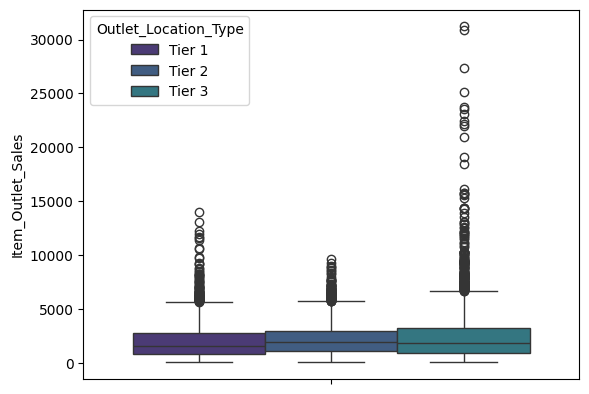

In [34]:
sns.boxplot(y="Item_Outlet_Sales", hue="Outlet_Location_Type", data=data)
plt.show()

#### Outlet_Type

<Axes: xlabel='count', ylabel='Outlet_Type'>

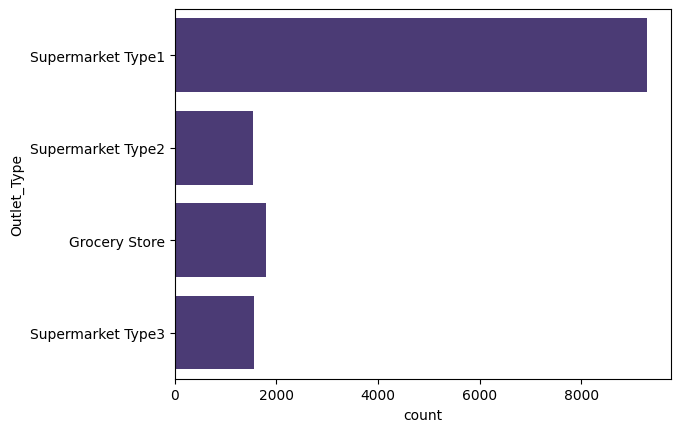

In [35]:
sns.countplot(data, y="Outlet_Type")

#### Correlations

In [36]:
print(data.columns)

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'Item_Outlet_Sales_log',
       'Item_Weight_filled_median', 'Item_Weight_filled_by_type',
       'Item_Weight_filled_by_id', 'Item_Visibility_sqrt', 'Item_MRP_cats',
       'MRP48_simil', 'MRP103_simil', 'MRP170_simil', 'MRP240_simil'],
      dtype='object')


In [92]:
data.corr(numeric_only=True)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Outlet_Sales_log,Item_Weight_filled_median,Item_Weight_filled_by_type,Item_Weight_filled_by_id,Item_Visibility_sqrt,MRP48_simil,MRP103_simil,MRP170_simil,MRP240_simil,Item_Visibility_st
Item_Weight,1.000000,-0.016348,0.037288,0.002878,0.228297,0.208287,1.000000,1.000000,1.000000,-0.013348,-0.021101,-0.030947,0.027724,0.022629,-0.016348
Item_Visibility,-0.016348,1.000000,-0.006351,-0.083678,-0.158813,-0.197179,-0.016621,-0.014176,-0.015342,0.949456,0.017546,0.000633,-0.013115,0.009543,1.000000
Item_MRP,0.037288,-0.006351,1.000000,0.000141,0.532261,0.564208,0.033777,0.034502,0.034644,-0.000711,-0.618500,-0.405076,0.350416,0.646979,-0.006351
Outlet_Establishment_Year,0.002878,-0.083678,0.000141,1.000000,-0.110786,0.017648,0.019592,0.001258,-0.000695,-0.064271,0.000303,0.000325,-0.000284,0.000747,-0.083678
Item_Outlet_Sales,0.228297,-0.158813,0.532261,-0.110786,1.000000,0.822925,0.155303,0.160823,0.145037,-0.149768,-0.330215,-0.223258,0.199455,0.339235,-0.158813
Item_Outlet_Sales_log,0.208287,-0.197179,0.564208,0.017648,0.822925,1.000000,0.171831,0.172065,0.157997,-0.165456,-0.450774,-0.149048,0.258566,0.298438,-0.197179
Item_Weight_filled_median,1.000000,-0.016621,0.033777,0.019592,0.155303,0.171831,1.000000,0.998121,0.911525,-0.013857,-0.018990,-0.028272,0.025112,0.020582,-0.016621
Item_Weight_filled_by_type,1.000000,-0.014176,0.034502,0.001258,0.160823,0.172065,0.998121,1.000000,0.913174,-0.011930,-0.018756,-0.029009,0.025263,0.021289,-0.014176
Item_Weight_filled_by_id,1.000000,-0.015342,0.034644,-0.000695,0.145037,0.157997,0.911525,0.913174,1.000000,-0.009902,-0.021374,-0.029191,0.027216,0.019562,-0.015342
Item_Visibility_sqrt,-0.013348,0.949456,-0.000711,-0.064271,-0.149768,-0.165456,-0.013857,-0.011930,-0.009902,1.000000,0.008518,0.002410,-0.014847,0.012165,0.949456


## Training Pipeline

In [38]:
# split features from labels
X = dataset.drop("Item_Outlet_Sales", axis=1)
y = dataset.loc[:, "Item_Outlet_Sales"]

In [39]:
print(dataset.columns)

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')


In [170]:
# define auxiliary features transformation functions 

# item weight: fill with mean value of the grouped by item type column or leave as 
# it is (tree-based algorithms are configured to handle NaNs)
def fill_weight_nan(X):
    # dictionary to get values to fill NaNs
    fillna_dict = X.groupby("Item_Type")["Item_Weight"].agg(["mean"]).to_dict()
    # fill NaNs
    X["Item_Weight"] = X["Item_Weight"].fillna(X["Item_Type"].map(fillna_dict["mean"]))
    return X[["Item_Weight"]].values

def fill_weight_name(function_transformer, feature_names_in):
    return ["Item_Weight"]

def add_indictor_var(X):
    # create indicator variable to mark the imputed weight values
    is_imputed = np.isnan(X)
    return is_imputed

def indicator_name(function_transformer, feature_names_in):
    return ["is_imputed"]


# Item fat content
def update_fat_cats(X):
    return X.replace({"LF": "Low Fat", "low fat": "Low Fat", "reg": "Regular"})


# Item MRP
def discr(X):
    # discretize MRP values
    return pd.cut(X.values.ravel(), bins=[0, 75, 135, 205, 300], labels=[1, 2, 3, 4]).reshape(-1, 1)


# default categorical encoding
cat_transform = make_pipeline(
    OneHotEncoder(handle_unknown="ignore", sparse_output=False)
)

weight_tranform = make_pipeline(
    FunctionTransformer(fill_weight_nan, feature_names_out=fill_weight_name, validate=False),
    StandardScaler(),
)

indicator_var = make_pipeline(
    FunctionTransformer(add_indictor_var, feature_names_out=indicator_name, validate=False)
)

fat_cont_trans = make_pipeline(
    FunctionTransformer(update_fat_cats, feature_names_out="one-to-one"),
    cat_transform
)

log_transform = make_pipeline(
    FunctionTransformer(np.log1p, inverse_func=np.expm1, feature_names_out="one-to-one"),
    StandardScaler(),
)

discr_pipeline = make_pipeline(
    FunctionTransformer(discr, feature_names_out="one-to-one"),
    cat_transform
)

# feature engineering: MRP
rbf_48 = make_pipeline(
    FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[48]], gamma=0.004), feature_names_out="one-to-one")
)

rbf_103 = make_pipeline(
    FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[103]], gamma=0.0015), feature_names_out="one-to-one")
)

rbf_165 = make_pipeline(
    FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[165]], gamma=0.001), feature_names_out="one-to-one")
)

rbf_240 = make_pipeline(
    FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[240]], gamma=0.002), feature_names_out="one-to-one")
)

# preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("imputed", weight_tranform, ["Item_Type", "Item_Weight"]),
        ("indicator", indicator_var, ["Item_Weight"]),
        ("updated_cats", fat_cont_trans, ["Item_Fat_Content"]),
        ("log", log_transform, ["Item_MRP"]),
        ("discrete", discr_pipeline, ["Item_MRP"]),
        ("rbf_48", rbf_48, ["Item_MRP"]),
        ("rbf_103", rbf_103, ["Item_MRP"]),
        ("rbf_165", rbf_165, ["Item_MRP"]),
        ("rbf_240", rbf_240, ["Item_MRP"]),
        ("ohe", cat_transform, ["Item_Identifier", "Item_Type", "Outlet_Identifier", "Outlet_Size", "Outlet_Location_Type", "Outlet_Type", "Outlet_Establishment_Year"]),
    ],
    remainder="passthrough"
)

# test the pipeline
X_tr = pd.DataFrame(preprocessor.fit_transform(X), columns=preprocessor.get_feature_names_out())
X_tr

,imputed__Item_Weight,indicator__is_imputed,updated_cats__Item_Fat_Content_Low Fat,updated_cats__Item_Fat_Content_Regular,log__Item_MRP,discrete__Item_MRP_1,discrete__Item_MRP_2,discrete__Item_MRP_3,discrete__Item_MRP_4,rbf_48__Item_MRP,...,ohe__Outlet_Establishment_Year_1985,ohe__Outlet_Establishment_Year_1987,ohe__Outlet_Establishment_Year_1997,ohe__Outlet_Establishment_Year_1998,ohe__Outlet_Establishment_Year_1999,ohe__Outlet_Establishment_Year_2002,ohe__Outlet_Establishment_Year_2004,ohe__Outlet_Establishment_Year_2007,ohe__Outlet_Establishment_Year_2009,remainder__Item_Visibility
0,-0.115417,0.0,1.0,0.0,-2.507760,1.0,0.0,0.0,0.0,4.306489e-01,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.111448
1,-0.115417,0.0,1.0,0.0,-2.479951,1.0,0.0,0.0,0.0,4.559319e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.111904
2,-0.115417,0.0,1.0,0.0,-2.479951,1.0,0.0,0.0,0.0,4.559319e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.111728
3,-0.115417,0.0,1.0,0.0,-2.457989,1.0,0.0,0.0,0.0,4.765362e-01,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,-0.703509,0.0,0.0,1.0,-2.420146,1.0,0.0,0.0,0.0,5.132763e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.045523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14199,0.002201,0.0,1.0,0.0,1.416576,0.0,0.0,0.0,1.0,3.160855e-80,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.069606
14200,0.002201,0.0,1.0,0.0,1.423178,0.0,0.0,0.0,1.0,6.752591e-81,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.070013
14201,0.002201,0.0,1.0,0.0,1.424642,0.0,0.0,0.0,1.0,4.787680e-81,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069561
14202,0.204448,1.0,1.0,0.0,1.428297,0.0,0.0,0.0,1.0,2.023736e-81,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069282


In [149]:
# define target metric
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# target transformer
target_transformer = make_pipeline(
    FunctionTransformer(np.log1p, inverse_func=np.expm1),
    #MinMaxScaler(),
    StandardScaler(),
)

In [150]:
# test training pipeline
model = TransformedTargetRegressor(XGBRegressor(n_estimators=100, learning_rate=0.1, 
                                                random_state=42, device="cuda:0"), 
                               transformer=target_transformer)
xgb = make_pipeline(preprocessor, model)
xgb_rmles = cross_val_score(xgb, X, y, scoring=make_scorer(rmsle), cv=5)
print(np.mean(xgb_rmles))

0.5764662868339567


### Feature Selection

In [174]:
y_tr = target_transformer.fit_transform(y.values.reshape(-1, 1))
xgb[-1].regressor.fit(X_tr, y_tr)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda:0', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [190]:
# get feature importances
f_import = xgb[-1].regressor.feature_importances_
f_import = pd.DataFrame(fi, index=preprocessor.get_feature_names_out(), columns=["importance"])

In [191]:
f_import["importance"].sort_values(ascending=False)[:30]

ohe__Outlet_Type_Grocery Store    0.174902
rbf_48__Item_MRP                  0.090975
rbf_240__Item_MRP                 0.060727
log__Item_MRP                     0.026809
rbf_103__Item_MRP                 0.019268
ohe__Outlet_Identifier_OUT027     0.015052
indicator__is_imputed             0.013754
rbf_165__Item_MRP                 0.011664
discrete__Item_MRP_4              0.009107
imputed__Item_Weight              0.007653
ohe__Item_Identifier_FDV08        0.006631
ohe__Item_Identifier_NCC07        0.006386
remainder__Item_Visibility        0.006246
ohe__Item_Type_Household          0.005814
ohe__Item_Identifier_NCK54        0.005672
ohe__Item_Identifier_FDN50        0.005280
ohe__Item_Identifier_FDR40        0.005133
ohe__Item_Identifier_NCD42        0.005126
ohe__Item_Identifier_FDP04        0.004846
ohe__Item_Identifier_FDZ47        0.004473
ohe__Item_Identifier_FDZ01        0.004422
ohe__Item_Type_Seafood            0.004217
ohe__Item_Identifier_FDQ28        0.004159
ohe__Item_T